# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Введение

***Задача***: разработать модель для определения стоимости автомобиля.<br>

***Условия***:
- метрика качества: RMSE
- значение RMSE должно быть не меньше 2500

***Документация к данным***:

*Признаки*
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя 

*Целевой признак* 

- Price — цена (евро)

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_validate 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
# считывание файла
df = pd.read_csv('autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# общая информация по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# проверяем наличие дубликатов
df.duplicated().sum()

4

In [6]:
# удаляем дубликаты
df = df.drop_duplicates()

In [7]:
# функция для категориальных значений
def countplot(x):
        print('Уникальные значения', x)
        print(df[x].unique())
        print('График распределения', x)
        sns.countplot(y=df[x])
        plt.show() 

In [8]:
# функция для числовых переменных
def hist_and_box_plot(x):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,10))

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=30, kde=True, stat='density', ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True) 

### Price 

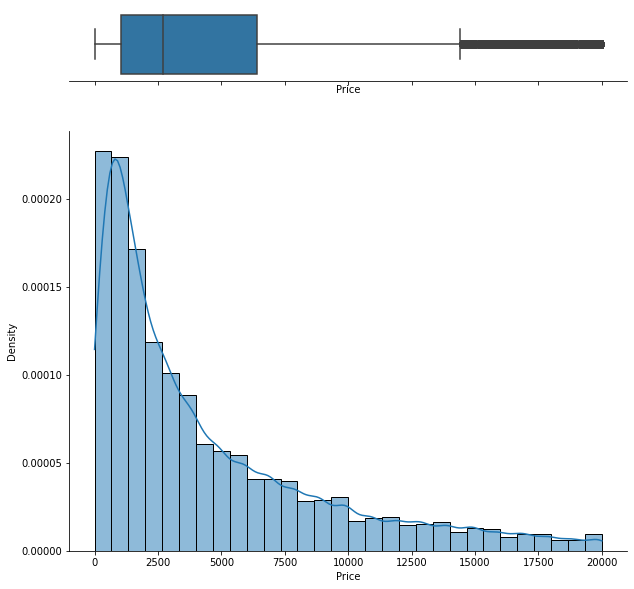

In [9]:
hist_and_box_plot(df['Price'])

In [10]:
df['Price'].describe() 

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Значения меньше 1000 выглядят неправдоподобно - возможно, там пропущен один 0. Домножим такие значения на 10.

In [12]:
# посмотрим на оставшиеся аномалии
df.query('Price < 1000').head() 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
12,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,37269,2016-04-01 13:16:16


Заменим аномальные значения медианой по столбцу.

In [13]:
df['Price'] = df['Price'].where(df['Price'] >= 1000, other=df['Price'].median()) 

Выбросы с крупными значениями оставим, т.к. они выглядят вполне реально.

### DateCrawled 

In [14]:
# приведём к типу datetime
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d') 

In [15]:
# найдём максимальное значение даты скачивания анкеты из базы
df['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

### VehicleType 

Уникальные значения VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
График распределения VehicleType


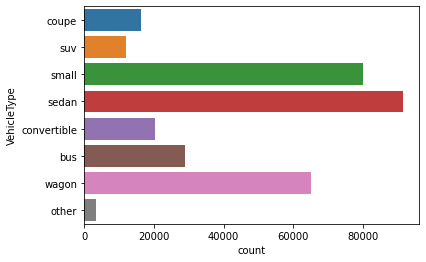

In [16]:
countplot('VehicleType')

### RegistrationYear

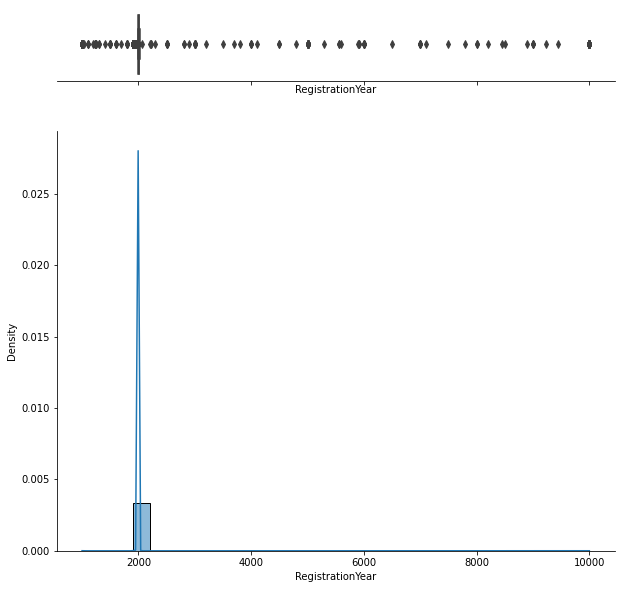

In [17]:
hist_and_box_plot(df['RegistrationYear'])

В колонке очень много аномальных значений. Автомобиль не может быть зарегистрирован позднее 2016 года - значит, нужно отсечь записи с датой регистрации позже 2016.

In [18]:
# посмотрим долю таких значений 
df.query('RegistrationYear > 2016')['Price'].count() / df.shape[0] 

0.041002920717339464

Такх значений менее 1%, поэтому можно удалить.

In [19]:
df = df.query('RegistrationYear <= 2016')

In [20]:
# # по правилу трёх сигм найдём нижнюю границу выбросов
MIN_YEAR = df['RegistrationYear'].mean() - 3 * np.std(df['RegistrationYear'])
MIN_YEAR

1960.4821327468444

In [21]:
# # посмотрим долю таких значений
df.query('RegistrationYear < @MIN_YEAR')['Price'].count() / df.shape[0] 

0.0017949887445377903

Таких значений тоже менее 1% - значит, можно их удалить.

In [22]:
df = df.query('RegistrationYear >= @MIN_YEAR') 

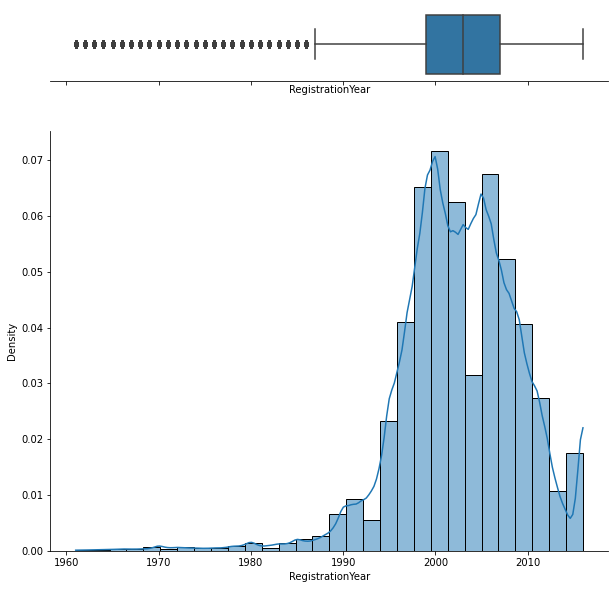

In [23]:
# посмотрим, кк изменились графики
hist_and_box_plot(df['RegistrationYear']) 

<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b> Тут все верно</div>

### Gearbox

Уникальные значения Gearbox
['manual' 'auto' nan]
График распределения Gearbox


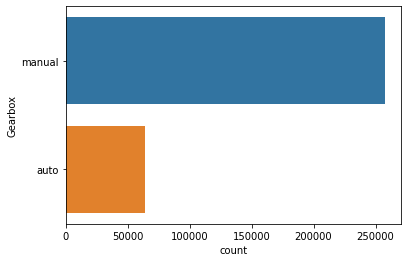

In [24]:
countplot('Gearbox')

### Power 

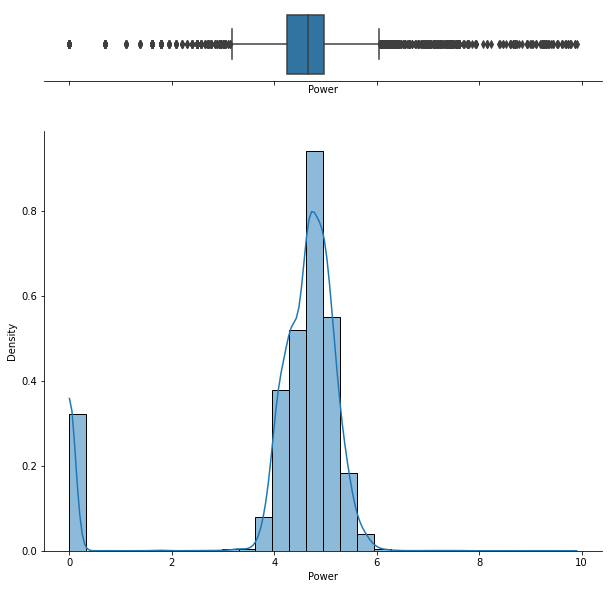

In [25]:
hist_and_box_plot(np.log1p(df['Power'])) 

In [26]:
# доля нулевых значений
df.query('Power == 0')['Power'].count() / df.shape[0]

0.10652811555752081

In [27]:
# удаляем записи с нулевым значением
df = df.query('Power > 0')

### Model

In [28]:
df['Model'].unique() 

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       'astra', '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'ka',
       'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er',
       'combo', 'corsa', '80', '147', 'meriva', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
 

### Kilometer

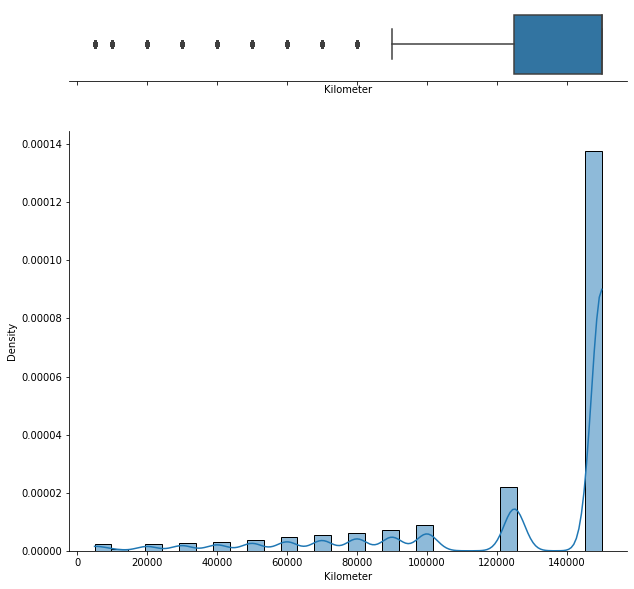

In [29]:
hist_and_box_plot(df['Kilometer']) 

Пробег может быть любой, поэтому ничего удалять не будем.

### RegistrationMonth

Уникальные значения RegistrationMonth
[ 5  8  6  7 10  0 12 11  2  3  1  4  9]
График распределения RegistrationMonth


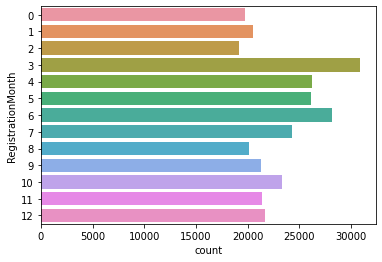

In [30]:
countplot('RegistrationMonth')

Посмотрим, сколько нулей в RegistrationMonth. 

In [31]:
df.query('RegistrationMonth == 0')['Price'].count() / df.shape[0]

0.06525497545267381

Нулей в колонке с месяцем около 0.6%. Предположим, что вместо 0 там должно быть 10 и заменим нулевые значения.

In [32]:
df['RegistrationMonth'] = df['RegistrationMonth'].where(df['RegistrationMonth'] != 0, other=10) 

### FuelType

Уникальные значения FuelType
['gasoline' 'petrol' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
График распределения FuelType


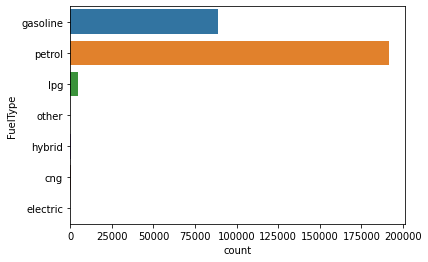

In [33]:
countplot('FuelType')

### Brand

Уникальные значения Brand
['audi' 'jeep' 'volkswagen' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'seat' 'honda' 'fiat' 'opel' 'mini'
 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'citroen' 'toyota' 'chevrolet'
 'dacia' 'daihatsu' 'saab' 'chrysler' 'jaguar' 'daewoo' 'rover' 'porsche'
 'trabant' 'land_rover' 'lada']
График распределения Brand


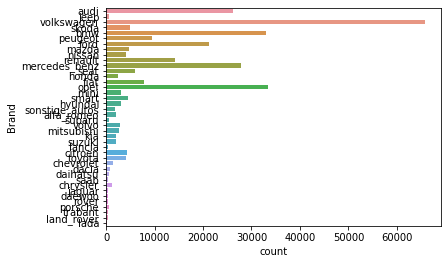

In [34]:
countplot('Brand')

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> График увеличить бы, а то надписи друг на друга наехали;(

</div>

### Repaired

Уникальные значения Repaired
['yes' nan 'no']
График распределения Repaired


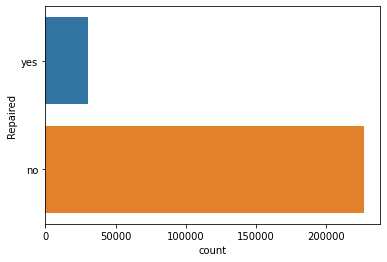

In [35]:
countplot('Repaired')

### DateCreated 

In [36]:
# приведём к типу datetime
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d')

Дата создания анкеты должна быть не позднее её скачивания из базы.

In [37]:
df.query('DateCreated > DateCrawled')['Price'].count() 

0

Таких записей нет, всё в порядке.

### NumberOfPictures

Посмотрим, сколько нулей в колонке NumberOfPictures.

In [38]:
df['NumberOfPictures'].value_counts()

0    303088
Name: NumberOfPictures, dtype: int64

### PostalCode 

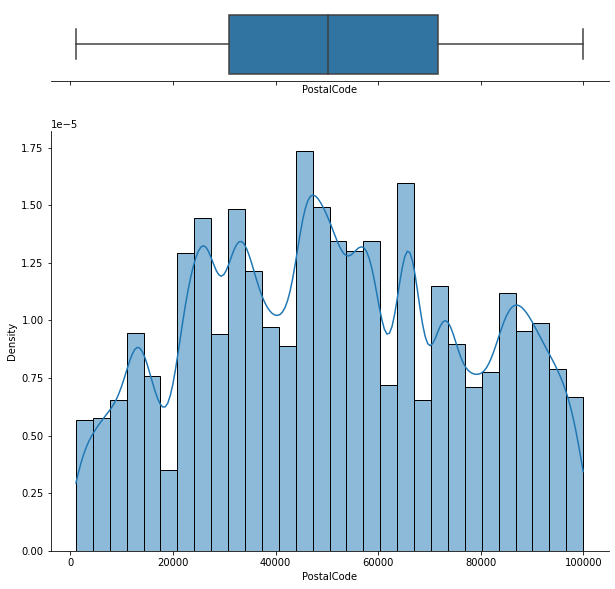

In [39]:
hist_and_box_plot(df['PostalCode'])

### LastSeen

In [40]:
# приведём к типу datetime
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d') 

Нужно проверить, что нет таких автомобилей, которые зарегистрированы после даты последней активности пользователя.

In [41]:
# функция получения даты регистрации авто
def to_date(row):
    year = str(row['RegistrationYear'])
    month = str(row['RegistrationMonth'])
    day = '1'
    
    date = pd.to_datetime(('-').join([year, month, day]), format='%Y-%m-%d')
    return date 

In [42]:
# создаём колонку с датой регистрации авто
df['RegistrationDate'] = df.apply(to_date, axis=1) 

In [43]:
df.head() 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,RegistrationDate
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-05-01
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,2004-08-01
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2001-06-01
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2008-07-01
5,2016-04-04 17:36:23,2700,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07,1995-10-01


In [44]:
# для записей, где авто зарегистрирован позднее последней активности, добавим метку
def registration_after_last_seen(row):
    registration = row['RegistrationDate']
    last_seen = row['LastSeen']
    
    if (last_seen - registration).days < 0:
        result = 1
    else:
        result = 0
    return result 

In [45]:
df['RegistrationAfterLastSeen'] = df.apply(registration_after_last_seen, axis=1) 

In [46]:
# посмотрим на эти записи
df.query('RegistrationAfterLastSeen == 1').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,RegistrationDate,RegistrationAfterLastSeen
16,2016-04-01 12:46:46,2700,NaN,2016,NaN,60,polo,150000,10,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46,2016-10-01,1
31,2016-03-29 16:57:02,2700,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07,2016-06-01,1
35,2016-03-08 07:54:46,2700,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50,2016-04-01,1
181,2016-03-21 14:43:48,3000,NaN,2016,auto,75,fabia,150000,10,petrol,skoda,NaN,2016-03-21,0,24782,2016-03-31 17:45:24,2016-10-01,1
200,2016-04-03 20:44:13,1999,NaN,2016,manual,110,almera,150000,9,gasoline,nissan,NaN,2016-04-03,0,10997,2016-04-05 21:17:18,2016-09-01,1


In [47]:
# посмотрим долю таких значений
df.query('RegistrationAfterLastSeen == 1')['Price'].count() / df.shape[0] 

0.01782980520508895

Эти объекты явно аномалии, их нужно удалить.

In [48]:
df = df.query('RegistrationAfterLastSeen == 0') 

In [49]:
# удаляем все колонки, которые не понадобятся для обучения модели
df = df.drop(columns=['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures', 'RegistrationDate', 'RegistrationAfterLastSeen'])

In [50]:
df.head() 

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,2700,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


### Обработка пропусков

Изучим пропуски в колонках.

In [51]:
df.isna().sum() 

Price                    0
VehicleType           6654
RegistrationYear         0
Gearbox               5293
Power                    0
Model                11269
Kilometer                0
RegistrationMonth        0
FuelType             14523
Brand                    0
Repaired             42967
dtype: int64

Во всех колонках с пропусками, кроме Repaired, есть значение other - им и заменим пропуски. В колонке Repaired пропуск, скорей всего, означает наличие ремонта, т.к. обычно отсутствие ремонта наоборот подчёркивают.

In [52]:
# заменяем пропуски значениями 
for column in df.columns:
    if df[column].isna().sum() > 0:
        if column == 'Repaired':
            df[column] = df[column].where(~df[column].isna(), other='yes')
        else:
            df[column] = df[column].where(~df[column].isna(), other='other')

In [53]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,2700,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [54]:
df.shape

(297684, 11)

In [55]:
297684/354369 

0.8400396197184291

После удаления выбросов осталось 84% данных.

## Обучение и анализ моделей

In [56]:
features = df.drop('Price', axis=1)
target = df['Price']

In [57]:
features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=.8, random_state=12345)

In [58]:
# разделяем числовые и категориальные колонки
integer_columns = features.select_dtypes(include=['int64']).columns.tolist() 
object_columns = features.select_dtypes(include=['object']).columns.tolist()  

In [59]:
# пайплайн для категориальных признаков
cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [60]:
# пайплайн для числовых признаков
num_pipe = Pipeline([('scaler', StandardScaler())]) 

In [61]:
# соединяем пайплайны вместе
transformer = ColumnTransformer(
                    transformers=[('cat', cat_pipe, object_columns),
                                 ('num', num_pipe, integer_columns)],
                                remainder='passthrough')

### Линейная регрессия

In [62]:
kf = KFold(n_splits=5, random_state=12345, shuffle=True)

In [63]:
# базовая модель линейной регрессии
lr = Pipeline([('transformer', transformer),
              ('lr', LinearRegression())])

In [65]:
# подбор гиперпараметров для линейной регрессии
params_lr = {
    'lr__fit_intercept': [True, False],
    'lr__positive': [True, False]
}

grid_lr = GridSearchCV(lr, param_grid=params_lr, cv=kf, 
                        scoring='neg_root_mean_squared_error').fit(features_train, target_train) 

In [66]:
results = grid_lr.cv_results_
best_index = grid_lr.best_index_

fit_time = results['mean_fit_time'].mean()
score_time = results['mean_score_time'].mean()
RMSE = results['mean_test_score'].max()

print(f"Fit time: {fit_time}\nPredict time: {score_time}\nBest RMSE: {RMSE}") 

Fit time: 30.805420476198197
Predict time: 0.33927851915359497
Best RMSE: -2953.095291277624


In [67]:
grid_lr.best_params_

{'lr__copy_X': True,
 'lr__fit_intercept': False,
 'lr__n_jobs': None,
 'lr__positive': True}

### Решающее дерево

In [68]:
# кодируем категориальные признаки на трейне и тесте порядковым кодированием
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan) 
features_encoded = pd.DataFrame(encoder.fit_transform(features_train[object_columns]), columns=object_columns)
features_train_ordinal = pd.concat([features_train[integer_columns].reset_index(drop=True), features_encoded.reset_index(drop=True)], axis=1)

features_test_encoded = pd.DataFrame(encoder.transform(features_test[object_columns]), columns=object_columns)
features_test_ordinal = pd.concat([features_test[integer_columns].reset_index(drop=True), features_test_encoded.reset_index(drop=True)], axis=1)

In [69]:
# базовая модель решающего дерева
dtr = DecisionTreeRegressor(random_state=12345)

In [76]:
%%time
# подбор гиперпараметров для решающего дерева
params_dtr = {
    'max_depth': [18, 19, 20],
    'min_samples_leaf': [7, 8, 9]
}

grid_dtr = GridSearchCV(dtr, param_grid=params_dtr, cv=kf, 
                        scoring='neg_root_mean_squared_error').fit(features_train_ordinal, target_train) 

CPU times: user 28.3 s, sys: 0 ns, total: 28.3 s
Wall time: 28.3 s


In [77]:
results = grid_dtr.cv_results_
best_index = grid_dtr.best_index_

fit_time = results['mean_fit_time'].mean()
score_time = results['mean_score_time'].mean()
RMSE = results['mean_test_score'].max()

print(f"Fit time: {fit_time}\nPredict time: {score_time}\nBest RMSE: {RMSE}") 

Fit time: 0.5998870001898872
Predict time: 0.012495496537950302
Best RMSE: -1795.1555599114406


In [78]:
grid_dtr.best_params_

{'max_depth': 19, 'min_samples_leaf': 8}

### Случайный лес

In [79]:
# базовая модель случайного леса
rfr = RandomForestRegressor(random_state=12345,
                           n_estimators=50)

In [84]:
%%time
# подбор гиперпараметров случайного леса
params_rfr = {
    'max_depth': [21, 22, 23],
    'min_samples_split': [8, 9, 10]
}

grid_rfr = GridSearchCV(rfr, param_grid=params_rfr, cv=kf,
                       scoring='neg_root_mean_squared_error').fit(features_train_ordinal, target_train)

CPU times: user 18min 25s, sys: 5.48 s, total: 18min 30s
Wall time: 18min 31s


In [85]:
results = grid_rfr.cv_results_
best_index = grid_rfr.best_index_

fit_time = results['mean_fit_time'].mean()
score_time = results['mean_score_time'].mean()
RMSE = results['mean_test_score'].max()

print(f"Fit time: {fit_time}\nPredict time: {score_time}\nBest RMSE: {RMSE}") 

Fit time: 23.413004133436417
Predict time: 0.6024158848656548
Best RMSE: -1596.00996653369


In [86]:
grid_rfr.best_params_

{'max_depth': 22, 'min_samples_split': 8}

In [87]:
rfr = grid_rfr.best_estimator_

### Catboost

In [88]:
# базовая модель catboost
catb = CatBoostRegressor(random_state=12345, 
                         cat_features=object_columns, 
                         iterations=100,
                         early_stopping_rounds=10,
                         learning_rate=0.1)

In [91]:
%%time
params_catb = {
    'depth': [14, 15, 16]
}

grid_catb = GridSearchCV(catb, param_grid=params_catb, cv=kf,
                        scoring='neg_root_mean_squared_error').fit(features_train, target_train, verbose=False)

CPU times: user 15min 39s, sys: 3min 35s, total: 19min 15s
Wall time: 19min 24s


In [92]:
results = grid_catb.cv_results_
best_index = grid_catb.best_index_

fit_time = results['mean_fit_time'].mean()
score_time = results['mean_score_time'].mean()
RMSE = results['mean_test_score'].max()

print(f"Fit time: {fit_time}\nPredict time: {score_time}\nBest RMSE: {RMSE}") 

Fit time: 69.52185559272766
Predict time: 0.09516167640686035
Best RMSE: -1611.4627172946825


In [93]:
grid_catb.best_params_

{'depth': 16}

### LightGBM

In [94]:
lgbm = LGBMRegressor(random_state=12345, learning_rate=0.3)

In [95]:
%%time
params_lgbm = {
    'max_depth': [15, 16]
}

grid_lgbm = GridSearchCV(lgbm, param_grid=params_lgbm, cv=kf,
                        scoring='neg_root_mean_squared_error').fit(features_train_ordinal, target_train)

CPU times: user 48min 15s, sys: 23.2 s, total: 48min 38s
Wall time: 49min 4s


In [96]:
results = grid_lgbm.cv_results_
best_index = grid_lgbm.best_index_

fit_time = results['mean_fit_time'].mean()
score_time = results['mean_score_time'].mean()
RMSE = results['mean_test_score'].max()

print(f"Fit time: {fit_time}\nPredict time: {score_time}\nBest RMSE: {RMSE}") 

Fit time: 273.17097330093384
Predict time: 0.39836556911468507
Best RMSE: -1699.257419716342


In [97]:
grid_lgbm.best_params_

{'max_depth': 15}

### Вывод

**Линейная регрессия**:
- Fit time: 30.805420476198197
- Predict time: 0.33927851915359497
- Best RMSE: -2953.095291277624

**Решающее дерево**:
- Fit time: 0.5998870001898872
- Predict time: 0.012495496537950302
- Best RMSE: -1795.1555599114406

**Случайный лес**:
- Fit time: 23.413004133436417
- Predict time: 0.6024158848656548
- Best RMSE: -1596.00996653369

**Catboost**:
- Fit time: 69.52185559272766
- Predict time: 0.09516167640686035
- Best RMSE: -1611.4627172946825

**LightGBM**:
- Fit time: 273.17097330093384
- Predict time: 0.39836556911468507
- Best RMSE: -1699.257419716342
    
Лучше всего работает модель случайного леса, её используем для получения предсказаний на тесте.

## Получение результата

### Случайный лес на тесте

In [98]:
rfr_pred = rfr.predict(features_test_ordinal)

In [99]:
np.sqrt(mean_squared_error(target_test, rfr_pred))

1581.970021973225